<a href="https://colab.research.google.com/github/Daphne-Qin/rice-datathon-2025/blob/main/Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
pip install imblearn

In [73]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# Train and Test

In [79]:
df_train = pd.read_csv("Train_and_Validate_EEG.csv")
df_test = pd.read_csv("Test_Set_EEG.csv")

# === TRAIN PREPROCESSING ===

# get features and labels (drop non-EEG data)
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]
features_raw = df_train.drop(columns=['ID', 'sex', 'eeg.date', 'main.disorder', 'specific.disorder'], errors='ignore')
labels = df_train['main.disorder']

# encode labels
labels_encoder = LabelEncoder()
labels_encoded = labels_encoder.fit_transform(labels)

# imputation
imputer = SimpleImputer(strategy="mean")
features_imputed = imputer.fit_transform(features_raw)

# standardization
scaler = StandardScaler()
features_imputed_scaled = scaler.fit_transform(features_imputed)

# select top 150 features
features_selector = ExtraTreesClassifier(n_estimators=200, random_state=42)
features_selector.fit(features_imputed_scaled, labels_encoded)
features_important = pd.Series(features_selector.feature_importances_, index=features_raw.columns)
features_top = features_important.nlargest(150).index
features_selected = df_train[features_top]
features_imputed_selected = imputer.fit_transform(features_selected)
features_scaled_selected = scaler.fit_transform(features_imputed_selected)

# train test split, generate more testing data with SMOTE
X_train, X_val, y_train, y_val = train_test_split(features_scaled_selected, labels_encoded, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# === MODEL ===

rf_model = RandomForestClassifier(n_estimators=1500, max_depth=25, min_samples_split=4, class_weight="balanced", random_state=42, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)

# validate and print metrics
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=labels_encoder.classes_)
print(f"Accuracy Score: {100*accuracy:.2f}%\n")
print("Classification Report:\n", report)

# === TEST ===

# preprocess test data
test_features_selected = df_test[features_top]
test_features_imputed_selected = imputer.transform(test_features_selected)
test_features_scaled_selected = scaler.transform(test_features_imputed_selected)

# predict on test data
test_predictions = rf_model.predict(test_features_scaled_selected)

# reverse encode
test_predictions_labels = labels_encoder.inverse_transform(test_predictions)

# === SUBMIT ===

submission_df = pd.DataFrame({'ID': df_test['ID'], 'main.disorder.class': test_predictions_labels})
submission_df.to_csv("submission.csv", index=False)

Accuracy Score: 32.75%

Classification Report:
                                     precision    recall  f1-score   support

                Addictive disorder       0.31      0.44      0.36        34
                  Anxiety disorder       0.14      0.05      0.07        20
                   Healthy control       0.42      0.40      0.41        20
                     Mood disorder       0.41      0.45      0.43        53
     Obsessive compulsive disorder       0.00      0.00      0.00         5
                     Schizophrenia       0.30      0.33      0.32        21
Trauma and stress related disorder       0.12      0.06      0.08        18

                          accuracy                           0.33       171
                         macro avg       0.24      0.25      0.24       171
                      weighted avg       0.30      0.33      0.31       171



# Visualizations

## Important Features

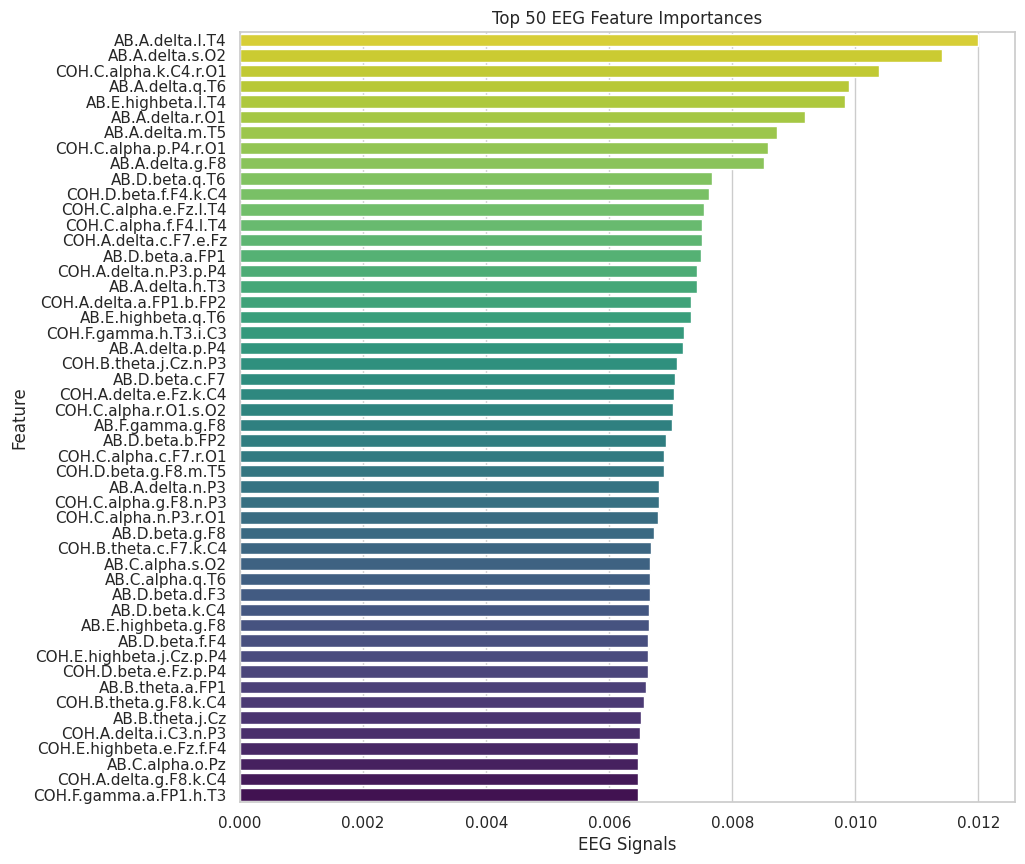

In [78]:
# get RF model important features
features_importances = rf_model.feature_importances_

# map importances to feature names
feature_names = features_top

# exclude non-EEG data
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': features_importances})
df_importance_filtered = df_importance[~df_importance['Feature'].str.contains('|'.join(['ID', 'sex', 'age', 'eeg.date', 'education', 'IQ']), case=False, na=False)]

# get top n values
top_n = 50
df_top_n = df_importance_filtered.sort_values(by='Importance', ascending=False).head(top_n)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=df_top_n, hue='Feature', palette='viridis_r', dodge=False, legend=False)
plt.title(f'Top {top_n} EEG Feature Importances')
plt.xlabel('Feature Importance')
plt.xlabel('EEG Signals')
plt.show()

## Confusion Matrix

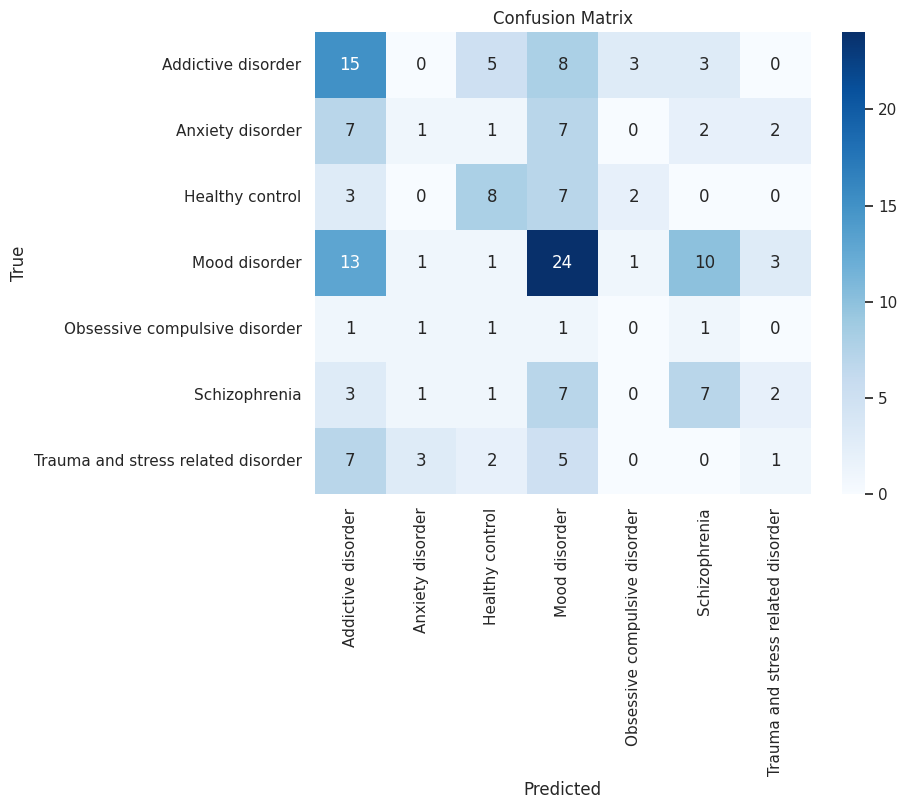

In [77]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_encoder.classes_, yticklabels=labels_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()